## **Identifying Key Contributors to Road Traffic Accidents Using XGBoost and Exploratory Data Analysis**
### Objectives
* To explore and analyze road traffic crash data to understand patterns and trends in accidents.
* To develop a predictive machine learning model to classify accident severity.
* To evaluate the performance of the predictive model using appropriate metrics such as accuracy, precision, recall and F1-score.
* To provide data-driven recommendations for improving road safety and reducing accident severity.

In [ ]:
# importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('seaborn-darkgrid')
sns.set_style('darkgrid', {'axes.facecolor':'0.9'})
from scipy.stats import f_oneway
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, recall_score

In [2]:
crashes=pd.read_csv('./data/Traffic_Crashes_-_Crashes.csv.gz', low_memory=False)
people=pd.read_csv('./data/Traffic_Crashes_-_People.csv.gz', low_memory=False)
vehicles=pd.read_csv('./data/Traffic_Crashes_-_Vehicles.csv.gz', low_memory=False)

In [3]:
crashes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54959 entries, 0 to 54958
Data columns (total 48 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   CRASH_RECORD_ID                54959 non-null  object 
 1   CRASH_DATE_EST_I               3503 non-null   object 
 2   CRASH_DATE                     54959 non-null  object 
 3   POSTED_SPEED_LIMIT             54959 non-null  int64  
 4   TRAFFIC_CONTROL_DEVICE         54959 non-null  object 
 5   DEVICE_CONDITION               54959 non-null  object 
 6   WEATHER_CONDITION              54959 non-null  object 
 7   LIGHTING_CONDITION             54959 non-null  object 
 8   FIRST_CRASH_TYPE               54959 non-null  object 
 9   TRAFFICWAY_TYPE                54959 non-null  object 
 10  LANE_CNT                       6 non-null      float64
 11  ALIGNMENT                      54959 non-null  object 
 12  ROADWAY_SURFACE_COND           54959 non-null 

In [4]:
crashes.columns

Index(['CRASH_RECORD_ID', 'CRASH_DATE_EST_I', 'CRASH_DATE',
       'POSTED_SPEED_LIMIT', 'TRAFFIC_CONTROL_DEVICE', 'DEVICE_CONDITION',
       'WEATHER_CONDITION', 'LIGHTING_CONDITION', 'FIRST_CRASH_TYPE',
       'TRAFFICWAY_TYPE', 'LANE_CNT', 'ALIGNMENT', 'ROADWAY_SURFACE_COND',
       'ROAD_DEFECT', 'REPORT_TYPE', 'CRASH_TYPE', 'INTERSECTION_RELATED_I',
       'NOT_RIGHT_OF_WAY_I', 'HIT_AND_RUN_I', 'DAMAGE', 'DATE_POLICE_NOTIFIED',
       'PRIM_CONTRIBUTORY_CAUSE', 'SEC_CONTRIBUTORY_CAUSE', 'STREET_NO',
       'STREET_DIRECTION', 'STREET_NAME', 'BEAT_OF_OCCURRENCE',
       'PHOTOS_TAKEN_I', 'STATEMENTS_TAKEN_I', 'DOORING_I', 'WORK_ZONE_I',
       'WORK_ZONE_TYPE', 'WORKERS_PRESENT_I', 'NUM_UNITS',
       'MOST_SEVERE_INJURY', 'INJURIES_TOTAL', 'INJURIES_FATAL',
       'INJURIES_INCAPACITATING', 'INJURIES_NON_INCAPACITATING',
       'INJURIES_REPORTED_NOT_EVIDENT', 'INJURIES_NO_INDICATION',
       'INJURIES_UNKNOWN', 'CRASH_HOUR', 'CRASH_DAY_OF_WEEK', 'CRASH_MONTH',
       'LATITUDE', 

In [5]:
crashes.CRASH_RECORD_ID.duplicated().sum()

0

In [6]:
crashes.MOST_SEVERE_INJURY.value_counts()

NO INDICATION OF INJURY     45514
NONINCAPACITATING INJURY     4982
REPORTED, NOT EVIDENT        3502
INCAPACITATING INJURY         809
FATAL                          47
Name: MOST_SEVERE_INJURY, dtype: int64

In [7]:
crashes['IS_SEVERE'] = (
    (crashes['INJURIES_INCAPACITATING'] > 0) |
    (crashes['INJURIES_FATAL'] > 0)
)

In [8]:
crashes.ROADWAY_SURFACE_COND.value_counts()

DRY                40314
UNKNOWN             7662
WET                 4588
SNOW OR SLUSH       1937
ICE                  271
OTHER                175
SAND, MUD, DIRT       12
Name: ROADWAY_SURFACE_COND, dtype: int64

In [9]:
crashes['ROADWAY_SURFACE_COND'].replace(['SAND, MUD, DIRT', 'OTHER'], 'OTHER_RARE', inplace=True)

In [10]:
crashes.WEATHER_CONDITION.value_counts()

CLEAR                       44097
UNKNOWN                      4525
RAIN                         2825
SNOW                         1751
CLOUDY/OVERCAST              1379
OTHER                         200
FREEZING RAIN/DRIZZLE          74
BLOWING SNOW                   42
SLEET/HAIL                     40
FOG/SMOKE/HAZE                 22
SEVERE CROSS WIND GATE          3
BLOWING SAND, SOIL, DIRT        1
Name: WEATHER_CONDITION, dtype: int64

In [11]:
crashes['WEATHER_CONDITION'].replace(['BLOWING SAND, SOIL, DIRT', 'OTHER'], 'OTHER_RARE', inplace=True)

In [12]:
crashes.groupby('ROADWAY_SURFACE_COND')['IS_SEVERE'].mean().sort_values(ascending=False)

ROADWAY_SURFACE_COND
WET              0.022886
DRY              0.016892
SNOW OR SLUSH    0.011874
OTHER_RARE       0.010695
ICE              0.007380
UNKNOWN          0.005612
Name: IS_SEVERE, dtype: float64

## In wet roadway surface the rate of injury severity is highest.

In [13]:
crashes['SPEED_BIN'] = pd.cut(
    crashes['POSTED_SPEED_LIMIT'],
    bins=[0, 25, 35, 45, 55, 65, 100],
    labels=['≤25', '30-35', '40-45', '50-55', '60-65', '65+'],
    include_lowest=True)

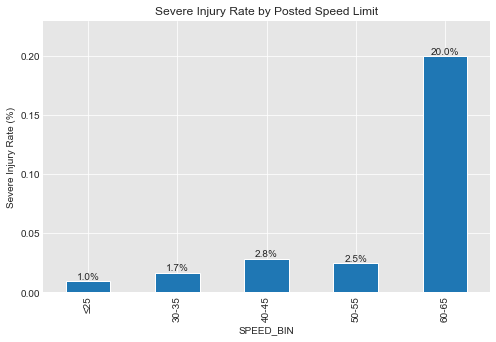

In [14]:
rates = crashes.groupby('SPEED_BIN')['IS_SEVERE'].mean()
rates = rates.dropna()
ax = rates.plot(kind='bar', figsize=(8,5))
plt.ylabel('Severe Injury Rate (%)')
plt.title('Severe Injury Rate by Posted Speed Limit')
plt.ylim(0, rates.max() * 1.15)
for i, rate in enumerate(rates):
    ax.text(
        i,
        rate,
        f"{rate:.1%}",
        ha='center',
        va='bottom',
        fontsize=10
    );

### The percentages represent the probability of a severe injury given a specific posted speed limit category. The likelihood of severe injuries in speed limits ranging from 60-65km/h is 20%.

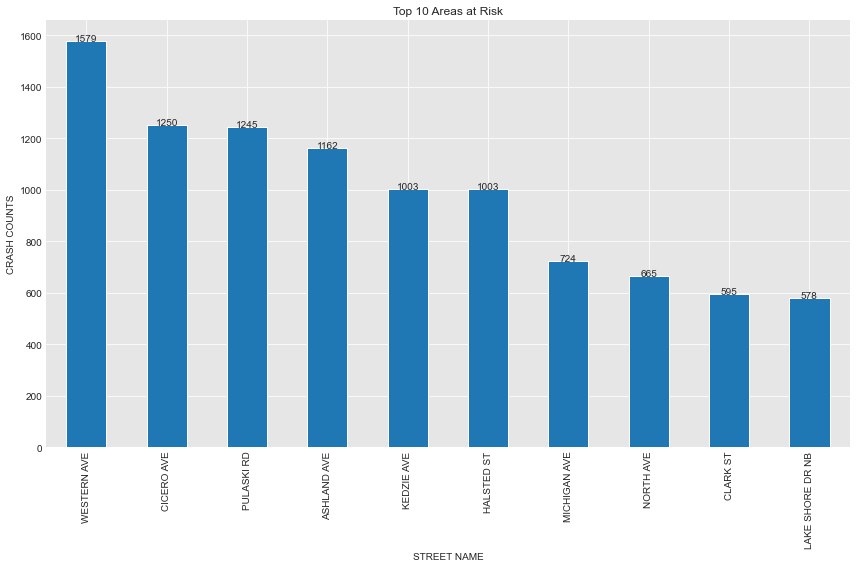

In [15]:
# top 10 areas at risk
top_10_risk_areas = crashes.STREET_NAME.value_counts().head(10)
top_10_risk_areas.plot(kind='bar', figsize=(12,8))
plt.title('Top 10 Areas at Risk')
plt.ylabel('CRASH COUNTS')
plt.xlabel('STREET NAME')
for i, rate in enumerate(top_10_risk_areas):
    plt.text(i, rate, s=f'{rate}', ha='center', fontsize=10)
plt.tight_layout();

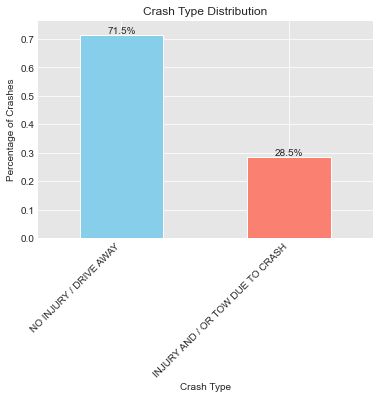

In [16]:
crash_type = crashes['CRASH_TYPE'].value_counts(normalize=True)
# Bar plot
crash_type.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Crash Type Distribution')
plt.xlabel('Crash Type')
plt.ylabel('Percentage of Crashes')
plt.ylim(0, crash_type.max() + 0.05)
plt.xticks(rotation=45, ha='right')
for i, rate in enumerate(crash_type):
    plt.text(
        i,
        rate + 0.005,
        f"{rate:.1%}",
        ha='center',
        fontsize=10
    );

## Analyzing primary contributing causes

In [17]:
crashes.PRIM_CONTRIBUTORY_CAUSE.value_counts().head(10)

UNABLE TO DETERMINE                       22702
FAILING TO YIELD RIGHT-OF-WAY              6533
FOLLOWING TOO CLOSELY                      4989
IMPROPER OVERTAKING/PASSING                3034
NOT APPLICABLE                             2457
FAILING TO REDUCE SPEED TO AVOID CRASH     2269
DRIVING SKILLS/KNOWLEDGE/EXPERIENCE        2189
IMPROPER TURNING/NO SIGNAL                 1899
IMPROPER LANE USAGE                        1833
IMPROPER BACKING                           1703
Name: PRIM_CONTRIBUTORY_CAUSE, dtype: int64

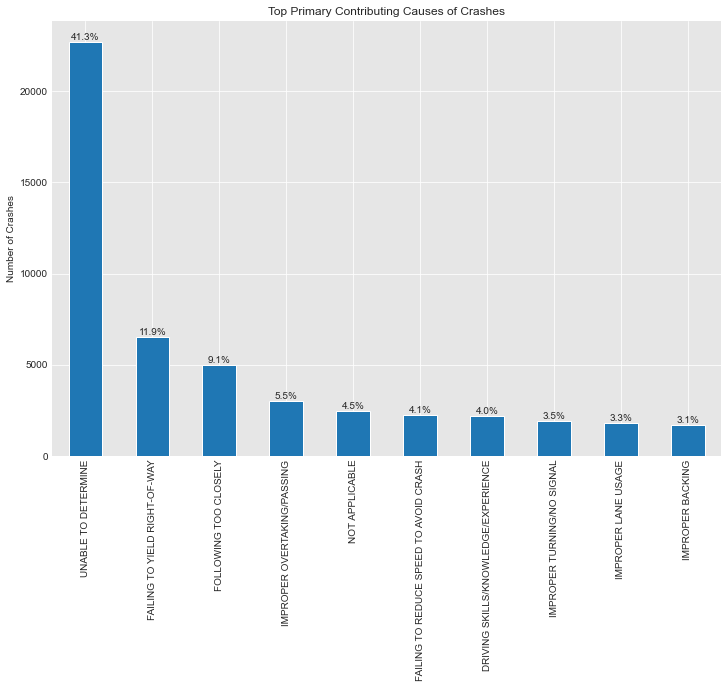

In [18]:
# Plot of top primary contributing causes of crashes
crashes.PRIM_CONTRIBUTORY_CAUSE.value_counts().head(10).plot(kind='bar', figsize=(12,8))
plt.title("Top Primary Contributing Causes of Crashes")
plt.ylabel("Number of Crashes")
plt.xticks(rotation=90)
total = crashes.PRIM_CONTRIBUTORY_CAUSE.value_counts().sum()
for i, rate in enumerate(crashes.PRIM_CONTRIBUTORY_CAUSE.value_counts().head(10)):
    plt.text(
        i,
        rate,
        f"{rate/total:.1%}",
        ha='center',
        va='bottom',
        fontsize=10
    );

## Time-Based Analysis

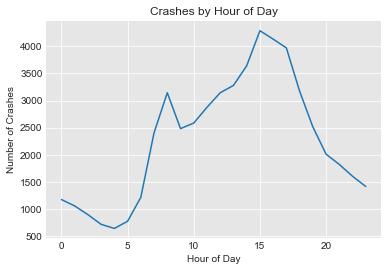

In [19]:
# Crash By Hour Plot
crashes['CRASH_HOUR'].value_counts().sort_index().plot(kind='line')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Crashes')
plt.title("Crashes by Hour of Day");

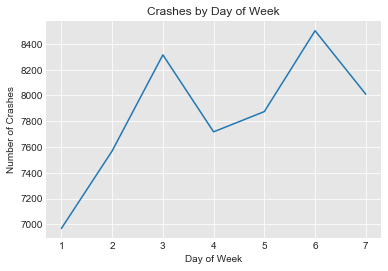

In [20]:
# Crashes By Day of Week Plot
crashes['CRASH_DAY_OF_WEEK'].value_counts().sort_index().plot(kind='line')
plt.xlabel('Day of Week')
plt.ylabel('Number of Crashes')
plt.title("Crashes by Day of Week");

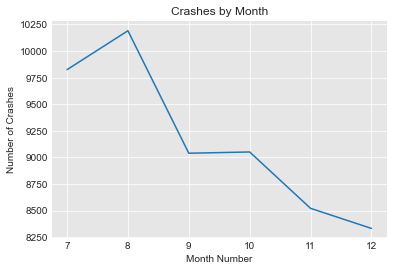

In [21]:
# Crash distribution monthly
crashes['CRASH_MONTH'].value_counts().sort_index().plot(kind='line')
plt.xlabel('Month Number')
plt.ylabel('Number of Crashes')
plt.title("Crashes by Month");

## Statistical Tests

H<sub>0</sub>: Weather condition does not affect injuries VS
H<sub>1</sub>: Weather affects injuries at 1% level of significance

In [22]:
groups = [
    crashes[crashes['WEATHER_CONDITION'] == w]['INJURIES_TOTAL'].dropna()
    for w in crashes['WEATHER_CONDITION'].unique()
]
f_oneway(*groups)

F_onewayResult(statistic=36.390952708299125, pvalue=7.888266197739882e-72)

## Weather significantly affects the number of injuries.

H<sub>0</sub>: Lighting condition does not affect injuries VS
H<sub>1</sub>: Lighting affects injuries at 1% level of significance

In [23]:
groups = [
    crashes[crashes['LIGHTING_CONDITION'] == w]['INJURIES_TOTAL'].dropna()
    for w in crashes['LIGHTING_CONDITION'].unique()
]
f_oneway(*groups)

F_onewayResult(statistic=88.11142785500279, pvalue=1.2734770215895415e-92)

## Lighting condition affects the number of injuries at 1% level of significance.

In [24]:
crashes=crashes[[
    'CRASH_RECORD_ID',
    'POSTED_SPEED_LIMIT',
    'TRAFFIC_CONTROL_DEVICE',
    'DEVICE_CONDITION',
    'WEATHER_CONDITION',
    'LIGHTING_CONDITION',
    'FIRST_CRASH_TYPE',
    'TRAFFICWAY_TYPE',
    'ALIGNMENT',
    'ROADWAY_SURFACE_COND',
    'ROAD_DEFECT',
    'NUM_UNITS',
    'CRASH_HOUR',
    'CRASH_DAY_OF_WEEK',
    'CRASH_MONTH',
    'LATITUDE',
    'LONGITUDE',
    'PRIM_CONTRIBUTORY_CAUSE'
]]

In [25]:
vehicles.columns

Index(['CRASH_UNIT_ID', 'CRASH_RECORD_ID', 'CRASH_DATE', 'UNIT_NO',
       'UNIT_TYPE', 'NUM_PASSENGERS', 'VEHICLE_ID', 'CMRC_VEH_I', 'MAKE',
       'MODEL', 'LIC_PLATE_STATE', 'VEHICLE_YEAR', 'VEHICLE_DEFECT',
       'VEHICLE_TYPE', 'VEHICLE_USE', 'TRAVEL_DIRECTION', 'MANEUVER',
       'TOWED_I', 'FIRE_I', 'OCCUPANT_CNT', 'EXCEED_SPEED_LIMIT_I', 'TOWED_BY',
       'TOWED_TO', 'AREA_00_I', 'AREA_01_I', 'AREA_02_I', 'AREA_03_I',
       'AREA_04_I', 'AREA_05_I', 'AREA_06_I', 'AREA_07_I', 'AREA_08_I',
       'AREA_09_I', 'AREA_10_I', 'AREA_11_I', 'AREA_12_I', 'AREA_99_I',
       'FIRST_CONTACT_POINT', 'CMV_ID', 'USDOT_NO', 'CCMC_NO', 'ILCC_NO',
       'COMMERCIAL_SRC', 'GVWR', 'CARRIER_NAME', 'CARRIER_STATE',
       'CARRIER_CITY', 'HAZMAT_PLACARDS_I', 'HAZMAT_NAME', 'UN_NO',
       'HAZMAT_PRESENT_I', 'HAZMAT_REPORT_I', 'HAZMAT_REPORT_NO',
       'MCS_REPORT_I', 'MCS_REPORT_NO', 'HAZMAT_VIO_CAUSE_CRASH_I',
       'MCS_VIO_CAUSE_CRASH_I', 'IDOT_PERMIT_NO', 'WIDE_LOAD_I',
       'TRAILER1_

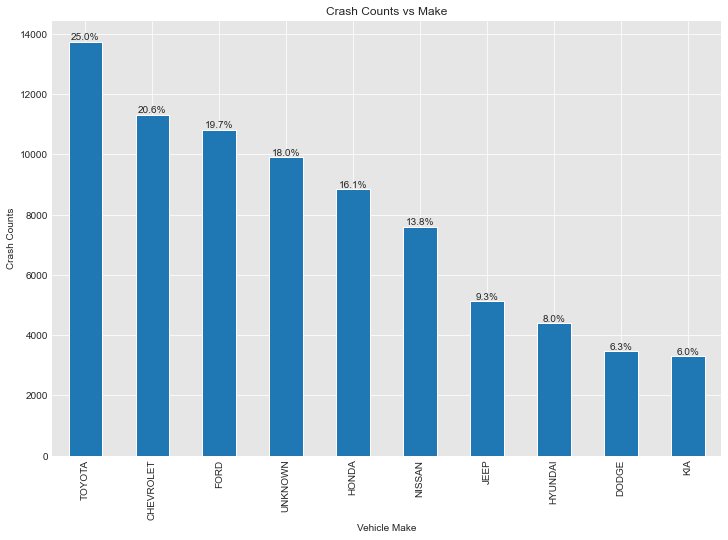

In [26]:
# Plot of Vehicle Make against their number of appearances in crashes.
vehicles.MAKE.value_counts().head(10).plot(kind='bar', figsize=(12,8))
plt.xlabel('Vehicle Make')
plt.ylabel('Crash Counts')
plt.title('Crash Counts vs Make')
for i, rate in enumerate(vehicles.MAKE.value_counts().head(10)):
    plt.text(
        i,
        rate,
        f"{rate/total:.1%}",
        ha='center',
        va='bottom',
        fontsize=10
    );

In [27]:
people.columns

Index(['PERSON_ID', 'PERSON_TYPE', 'CRASH_RECORD_ID', 'VEHICLE_ID',
       'CRASH_DATE', 'SEAT_NO', 'CITY', 'STATE', 'ZIPCODE', 'SEX', 'AGE',
       'DRIVERS_LICENSE_STATE', 'DRIVERS_LICENSE_CLASS', 'SAFETY_EQUIPMENT',
       'AIRBAG_DEPLOYED', 'EJECTION', 'INJURY_CLASSIFICATION', 'HOSPITAL',
       'EMS_AGENCY', 'EMS_RUN_NO', 'DRIVER_ACTION', 'DRIVER_VISION',
       'PHYSICAL_CONDITION', 'PEDPEDAL_ACTION', 'PEDPEDAL_VISIBILITY',
       'PEDPEDAL_LOCATION', 'BAC_RESULT', 'BAC_RESULT VALUE',
       'CELL_PHONE_USE'],
      dtype='object')

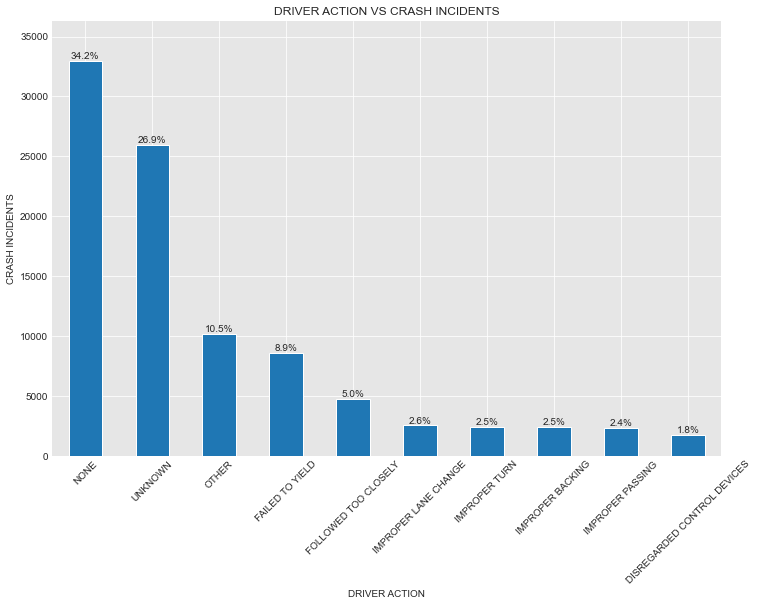

In [28]:
# Plot of Driver Action Count.
people.DRIVER_ACTION.value_counts().head(10).plot(kind='bar', figsize=(12,8))
plt.title('DRIVER ACTION VS CRASH INCIDENTS')
plt.xlabel('DRIVER ACTION')
plt.ylabel('CRASH INCIDENTS')
plt.xticks(rotation=45)
plt.ylim(0, people.DRIVER_ACTION.value_counts().max() * 1.1)
total = people.DRIVER_ACTION.value_counts().sum()
for i, rate in enumerate(people.DRIVER_ACTION.value_counts().head(10)):
    plt.text(
        i,
        rate,
        f"{rate/total:.1%}",
        ha='center',
        va='bottom',
        fontsize=10
    );

In [29]:
vehicle_agg = vehicles.groupby('CRASH_RECORD_ID').agg({
    'OCCUPANT_CNT': 'sum'
}).reset_index()

In [30]:
vehicle_agg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54959 entries, 0 to 54958
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CRASH_RECORD_ID  54959 non-null  object 
 1   OCCUPANT_CNT     54959 non-null  float64
dtypes: float64(1), object(1)
memory usage: 858.9+ KB


In [31]:
people_agg = people.groupby('CRASH_RECORD_ID').agg({
    'AGE': 'mean',
    'SAFETY_EQUIPMENT': lambda x: ((x == 'SAFETY BELT USED') | 
                                   (x == 'BICYCLE HELMET (PEDACYCLIST INVOLVED ONLY)') |
                                   (x == 'CHILD RESTRAINT - REAR FACING') |
                                   (x == 'CHILD RESTRAINT - FORWARD FACING') |
                                   (x == 'BOOSTER SEAT')).sum()
}).reset_index()

In [32]:
people_agg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54854 entries, 0 to 54853
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CRASH_RECORD_ID   54854 non-null  object 
 1   AGE               45740 non-null  float64
 2   SAFETY_EQUIPMENT  54854 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 1.3+ MB


In [33]:
people_agg.AGE.fillna(people_agg.AGE.mean(), inplace=True)

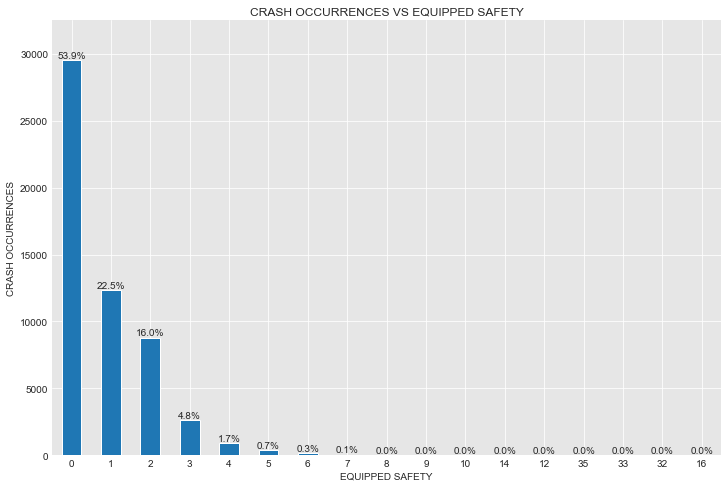

In [34]:
# Crash occurence vs safety equipment plot
equipment_rates=people_agg.SAFETY_EQUIPMENT.value_counts()
equipment_rates.plot(kind='bar', figsize=(12,8))
plt.title('CRASH OCCURRENCES VS EQUIPPED SAFETY')
plt.xlabel('EQUIPPED SAFETY')
plt.ylabel('CRASH OCCURRENCES')
plt.xticks(rotation=0)
plt.ylim(0, equipment_rates.max() * 1.1)
total = equipment_rates.sum()
for i, rate in enumerate(equipment_rates):
    plt.text(
        i,
        rate,
        f"{rate/total:.1%}",
        ha='center',
        va='bottom',
        fontsize=10
    );

In [35]:
# Merging DataFrames.
vehicle_people_df=pd.merge(people_agg, vehicle_agg, on='CRASH_RECORD_ID', how='inner')
final_df=pd.merge(crashes, vehicle_people_df, on='CRASH_RECORD_ID', how='inner')

In [36]:
final_df.isna().sum()

CRASH_RECORD_ID              0
POSTED_SPEED_LIMIT           0
TRAFFIC_CONTROL_DEVICE       0
DEVICE_CONDITION             0
WEATHER_CONDITION            0
LIGHTING_CONDITION           0
FIRST_CRASH_TYPE             0
TRAFFICWAY_TYPE              0
ALIGNMENT                    0
ROADWAY_SURFACE_COND         0
ROAD_DEFECT                  0
NUM_UNITS                    0
CRASH_HOUR                   0
CRASH_DAY_OF_WEEK            0
CRASH_MONTH                  0
LATITUDE                   558
LONGITUDE                  558
PRIM_CONTRIBUTORY_CAUSE      0
AGE                          0
SAFETY_EQUIPMENT             0
OCCUPANT_CNT                 0
dtype: int64

In [37]:
final_df.dropna(inplace=True)

In [38]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54296 entries, 0 to 54853
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   CRASH_RECORD_ID          54296 non-null  object 
 1   POSTED_SPEED_LIMIT       54296 non-null  int64  
 2   TRAFFIC_CONTROL_DEVICE   54296 non-null  object 
 3   DEVICE_CONDITION         54296 non-null  object 
 4   WEATHER_CONDITION        54296 non-null  object 
 5   LIGHTING_CONDITION       54296 non-null  object 
 6   FIRST_CRASH_TYPE         54296 non-null  object 
 7   TRAFFICWAY_TYPE          54296 non-null  object 
 8   ALIGNMENT                54296 non-null  object 
 9   ROADWAY_SURFACE_COND     54296 non-null  object 
 10  ROAD_DEFECT              54296 non-null  object 
 11  NUM_UNITS                54296 non-null  int64  
 12  CRASH_HOUR               54296 non-null  int64  
 13  CRASH_DAY_OF_WEEK        54296 non-null  int64  
 14  CRASH_MONTH           

## MODELLING

In [39]:
# Target and feature selection
target = final_df.PRIM_CONTRIBUTORY_CAUSE
features = final_df.drop(columns=['CRASH_RECORD_ID', 'PRIM_CONTRIBUTORY_CAUSE'], axis=1)

In [40]:
target.value_counts().sort_values()

MOTORCYCLE ADVANCING LEGALLY ON RED LIGHT                                               1
BICYCLE ADVANCING LEGALLY ON RED LIGHT                                                  2
DISREGARDING YIELD SIGN                                                                 4
PASSING STOPPED SCHOOL BUS                                                             10
OBSTRUCTED CROSSWALKS                                                                  10
TEXTING                                                                                11
HAD BEEN DRINKING (USE WHEN ARREST IS NOT MADE)                                        30
DISTRACTION - OTHER ELECTRONIC DEVICE (NAVIGATION DEVICE, DVD PLAYER, ETC.)            34
RELATED TO BUS STOP                                                                    38
TURNING RIGHT ON RED                                                                   45
ANIMAL                                                                                 51
CELL PHONE

In [41]:
target_clean = target.where(
    target.map(target.value_counts()) >= 50,
    other='OTHER'
)

In [42]:
X_train, X_test, y_train, y_test = train_test_split(features, target_clean, test_size=0.3, random_state=42, stratify=target_clean)

In [43]:
# Instantiate the encoder
encoder = LabelEncoder()

# Fit and transform the training data
train_encoded=encoder.fit_transform(y_train)

# Transform the test data
test_encoded=encoder.transform(y_test)

# Your code here to inspect the values of y_train and y_test
print(list(train_encoded))
print(list(test_encoded))

[16, 18, 25, 25, 25, 18, 13, 25, 17, 25, 25, 25, 25, 15, 13, 14, 19, 6, 25, 9, 25, 25, 25, 14, 8, 14, 19, 4, 20, 25, 14, 25, 19, 25, 13, 25, 16, 14, 19, 14, 20, 25, 9, 17, 25, 13, 15, 18, 25, 14, 9, 9, 14, 12, 13, 7, 25, 16, 9, 12, 9, 25, 25, 9, 13, 19, 16, 14, 14, 25, 13, 19, 13, 19, 25, 25, 15, 25, 25, 16, 25, 13, 25, 13, 25, 25, 13, 25, 25, 25, 13, 25, 25, 25, 12, 12, 25, 25, 8, 14, 13, 13, 19, 8, 25, 25, 9, 25, 19, 18, 17, 25, 14, 9, 14, 14, 25, 17, 12, 19, 25, 25, 25, 25, 15, 25, 13, 16, 25, 19, 25, 25, 25, 25, 14, 16, 17, 17, 25, 25, 14, 6, 19, 10, 14, 13, 9, 14, 18, 25, 25, 16, 15, 25, 25, 2, 25, 25, 25, 16, 13, 25, 14, 2, 14, 19, 9, 25, 13, 19, 13, 14, 25, 25, 25, 5, 25, 25, 16, 25, 25, 25, 25, 25, 20, 19, 25, 19, 16, 13, 28, 17, 6, 13, 25, 25, 25, 18, 15, 14, 13, 12, 12, 9, 25, 25, 25, 17, 25, 13, 15, 8, 9, 19, 9, 25, 25, 19, 9, 5, 25, 25, 25, 25, 19, 25, 25, 25, 14, 25, 17, 13, 14, 25, 25, 18, 25, 9, 25, 17, 13, 14, 25, 13, 17, 13, 15, 19, 13, 5, 16, 25, 25, 25, 25, 1, 25, 25

In [44]:
categorical_cols = X_train.select_dtypes(include='object').columns
numeric_cols = X_train.select_dtypes(exclude='object').columns
print(categorical_cols)
print(numeric_cols)

Index(['TRAFFIC_CONTROL_DEVICE', 'DEVICE_CONDITION', 'WEATHER_CONDITION',
       'LIGHTING_CONDITION', 'FIRST_CRASH_TYPE', 'TRAFFICWAY_TYPE',
       'ALIGNMENT', 'ROADWAY_SURFACE_COND', 'ROAD_DEFECT'],
      dtype='object')
Index(['POSTED_SPEED_LIMIT', 'NUM_UNITS', 'CRASH_HOUR', 'CRASH_DAY_OF_WEEK',
       'CRASH_MONTH', 'LATITUDE', 'LONGITUDE', 'AGE', 'SAFETY_EQUIPMENT',
       'OCCUPANT_CNT'],
      dtype='object')


In [45]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', dtype=int), categorical_cols),
        ('num', StandardScaler(), numeric_cols)
    ]
)

In [46]:
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

In [47]:
rf = RandomForestClassifier(class_weight='balanced', random_state=42)

rf_param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [None, 5],
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [3, 5]
}

rf_grid_search = GridSearchCV(
    rf, 
    param_grid=rf_param_grid, 
    cv=3,
    n_jobs=-1,
    verbose=1
)

rf_grid_search.fit(X_train_processed, train_encoded)

Fitting 3 folds for each of 32 candidates, totalling 96 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:  3.3min finished


GridSearchCV(cv=3,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=42),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 5], 'min_samples_leaf': [3, 5],
                         'min_samples_split': [2, 5],
                         'n_estimators': [50, 100]},
             verbose=1)

In [48]:
print(f"Testing Accuracy: {rf_grid_search.best_score_ :.2%}")
print("")
print(f"Optimal Parameters: {rf_grid_search.best_params_}")

Testing Accuracy: 31.73%

Optimal Parameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 100}


In [ ]:
rf_clf_2=RandomForestClassifier(criterion='entropy', max_depth=None, min_samples_leaf=3, min_samples_split=2, n_estimators=100, class_weight='balanced', random_state=42)
rf_clf_2.fit(X_train_processed, train_encoded)
pred=rf_clf_2.predict(X_test_processed)
print(classification_report(test_encoded, pred))

              precision    recall  f1-score   support

           0       0.24      0.47      0.32        15
           1       0.00      0.00      0.00        17
           2       0.00      0.00      0.00        23
           3       0.00      0.00      0.00        22
           4       0.15      0.75      0.25       142
           5       0.32      0.68      0.43       309
           6       0.04      0.01      0.02       100
           7       0.00      0.00      0.00        47
           8       0.11      0.20      0.14       105
           9       0.14      0.05      0.07       644
          10       0.05      0.09      0.07        87
          11       0.05      0.04      0.04        25
          12       0.18      0.02      0.03       676
          13       0.38      0.24      0.29      1940
          14       0.38      0.73      0.50      1486
          15       0.20      0.54      0.29       502
          16       0.19      0.13      0.16       538
          17       0.22    

## The recall is so low due to severe class imbalance.

## Now for Synthetic Minority Oversampling technique (SMOTE)

In [50]:
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_processed, train_encoded)

In [ ]:
rf = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',   
    max_depth=None,             
    min_samples_leaf=3,       
    min_samples_split=2,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train_res, y_train_res)

In [ ]:
y_pred_rf = rf.predict(X_test_processed)

In [ ]:
print(classification_report(test_encoded, y_pred_rf))

              precision    recall  f1-score   support

       False       0.99      0.83      0.90     16200
        True       0.06      0.64      0.10       257

    accuracy                           0.83     16457
   macro avg       0.52      0.73      0.50     16457
weighted avg       0.98      0.83      0.89     16457



In [ ]:
def plot_feature_importances(model):
    n_features = X_train_processed.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), preprocessor.get_feature_names_out()) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

plot_feature_importances(rf)

## XGBoost

In [ ]:
# Instantiate XGBClassifier
clf = XGBClassifier()

# Fit XGBClassifier
clf.fit(X_train_res, y_train_res)

# Predict on training and test sets
training_preds = clf.predict(X_train_processed)
test_preds = clf.predict(X_test_processed)

print('Training Accuracy: {:.4}%'.format(accuracy_score(train_encoded, training_preds) * 100))
print('Validation accuracy: {:.4}%'.format(accuracy_score(test_encoded, test_preds) * 100))

Training Accuracy: 98.66%
Validation accuracy: 98.38%
Training Recall: 0.1436%
Validation Recall: 0.0%


## Very low recall

In [ ]:
scale_pos_weight = (
    y_train.value_counts()[0] / y_train.value_counts()[1]
)
model = XGBClassifier(
    n_estimators=100,            
    learning_rate=0.03,
    subsample=0.8,
    colsample_bytree=0.8,                
    scale_pos_weight=scale_pos_weight,
    eval_metric='aucpr',
    random_state=42
)
model.fit(X_train_res, y_train_res)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=400, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

In [ ]:
param_grid = {
    'max_depth': [3, 4, 5],
    'min_child_weight': [5, 10, 20],
    'gamma': [0, 1, 5]
}
grid = GridSearchCV(
    model,
    param_grid,
    scoring='f1',
    cv=3,
    n_jobs=-1
)
grid.fit(X_train_res, y_train_res)
best_model = grid.best_estimator_

In [ ]:
y_pred = best_model.predict(X_test_processed)
print(classification_report(test_encoded, y_pred, digits=3))

              precision    recall  f1-score   support

       False      1.000     0.725     0.840     16200
        True      0.054     0.996     0.103       257

    accuracy                          0.729     16457
   macro avg      0.527     0.860     0.472     16457
weighted avg      0.985     0.729     0.829     16457



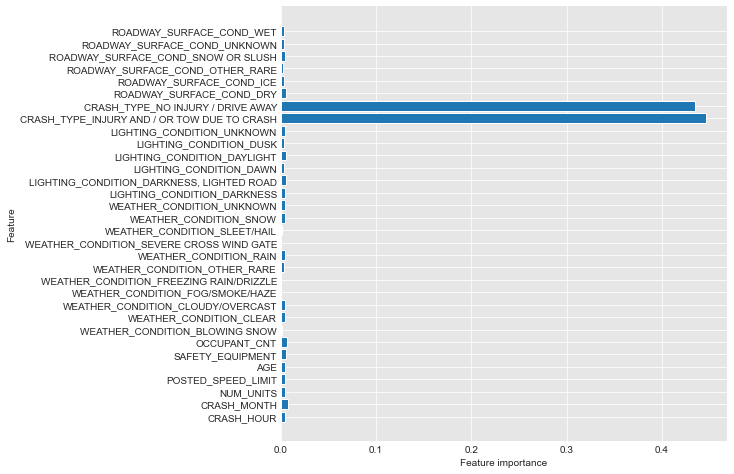

In [ ]:
plot_feature_importances(best_model)

## The most important feature in our xgboost model is crash type injury and or tow due to crash.